# Simple example
Please find below a simple example of an inverted pendulum. The goal is, by using only 
side pushes, to bring the wand upward. 

The ocp to solve is as follow:
- Movement of $1s$ separted into $50$ shooting points
- States variables are the generalized position (q) and velocities (qdot)
- Side translation is bounded to $\pm10\ m$, and rotation to $\pm2\pi\ rad$. Velocities are bounded to $\pm10\ m/s$ and $\pm31.4\ rad/s$, respectively
- Control variables are the generalized forces (tau) 
- Side translation force is bounded to $\pm100\ N$ and the rotation force is not allowed (bonded to $0\ Nm$)
- Cost functions: minimize the side pushes forces at all time
- Initial guess is arbitrarily set to $0$ for all the variables

In [1]:
# So first, let's import all the required classes 
import biorbd_casadi as biorbd
from bioptim import *
from ipyvtklink import ViewInteractiveWidget

In [2]:
# Now let's define the actual ocp

# Let's load a model and define some aliases
model_path = "models/pendulum.bioMod"
model = biorbd.Model(model_path)
nq = model.nbQ()  # Number of degrees of freedom in the model

# Define the time of movement and number of shooting point
final_time = 1
n_shoot = 30

# Select the torque driven Dynamics
dynamics = Dynamics(DynamicsFcn.TORQUE_DRIVEN)

# Define the path constraints of the states (x) and controls (u)
x_bounds = QAndQDotBounds(model)  # Use the state bounds defined in the bioMod file
x_bounds[:, [0, -1]] = 0  # Make sure initial position and rotation and velocities (:) are null at the beginning (0) and the end (-1)
x_bounds[1, -1] = 3.14  # Except for the final (-1) rotation (1)

u_bounds = Bounds([-100] * nq, [100] * nq)  # Define all the control bounds to be plus or minus 100
u_bounds[1, :] = 0  # Except for the rotation motor which is deactivated

# Define the objective functions
objective_functions = Objective(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key='tau')  # Minimize the generalized forces

# Define the initial guesses for states (x) and controls (u)
x_init = InitialGuess([0] * nq * 2)  # Set initial guesses for generalized coordinates and velocities to 0
u_init = InitialGuess([0] * nq)  # Set initial guesses for generalized forces 0

# Send all this to the ocp structure
ocp = OptimalControlProgram(
    model, 
    dynamics, 
    n_shoot, 
    final_time, 
    x_init=x_init, 
    u_init=u_init, 
    x_bounds=x_bounds,
    u_bounds=u_bounds,
    objective_functions=objective_functions,
)

# Have a look on the problem
ocp.print(to_console=True,to_graph=False)

PHASE: 0
**********
BOUNDS:
STATES: InterpolationType.CONSTANT_WITH_FIRST_AND_LAST_DIFFERENT
                    Beginning           Middle              End                 
q_Seg1_TransY_0     [0.0, 0.0]          [-1.0, 5.0]         [0.0, 0.0]          
q_Seg1_RotX_0       [0.0, 0.0]          [-6.283, 6.283]     [3.14, 3.14]        
qdot_Seg1_TransY_0  [0.0, 0.0]          [-31.416, 31.416]   [0.0, 0.0]          
qdot_Seg1_RotX_0    [0.0, 0.0]          [-31.416, 31.416]   [0.0, 0.0]          
**********
CONTROLS: InterpolationType.CONSTANT_WITH_FIRST_AND_LAST_DIFFERENT
                   Beginning           Middle              End                 
tau_Seg1_TransY_0  [-100.0, 100.0]     [-100.0, 100.0]     [-100.0, 100.0]     
tau_Seg1_RotX_0    [0.0, 0.0]          [0.0, 0.0]          [0.0, 0.0]          
**********
PARAMETERS: 


**********
MODEL: ./models/pendulum.bioMod
PHASE DURATION: 1 s
SHOOTING NODES : 30
DYNAMICS: TORQUE_DRIVEN
ODE: RK4
**********

*** Lagrange: 
MINIMIZE_CONTRO

In [3]:
# Let's solve the ocp!
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      613
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      291

Total number of variables............................:      146
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      146
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality c

Solver reported time: 1.408114442 sec
Real time: 1.4086976839989802 sec

---- COST FUNCTION VALUES ----
PHASE 0
MINIMIZE_CONTROL: -0.01 (weighted 41.58259426152732)

Sum cost functions: 41.58259426152732
------------------------------

--------- CONSTRAINTS ---------
PHASE 0
CONTINUITY: 1.6497046784191838e-13

------------------------------


/home/fb/miniconda3/envs/bioptim/lib/python3.10/site-packages/bioptim/optimization/solution.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_vector.append(sum(time_phase[: p + 1]) + np.array(flat_time))


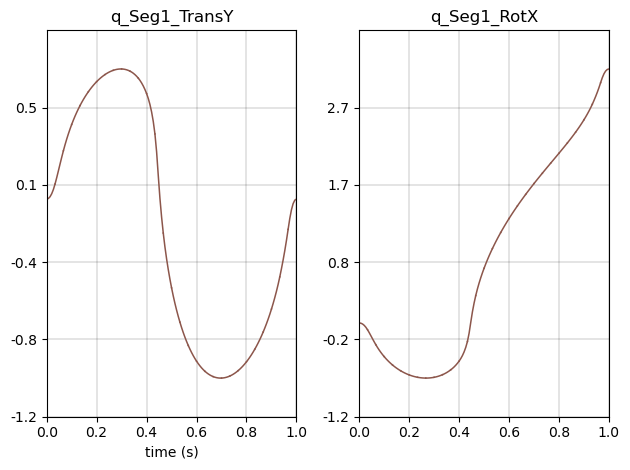

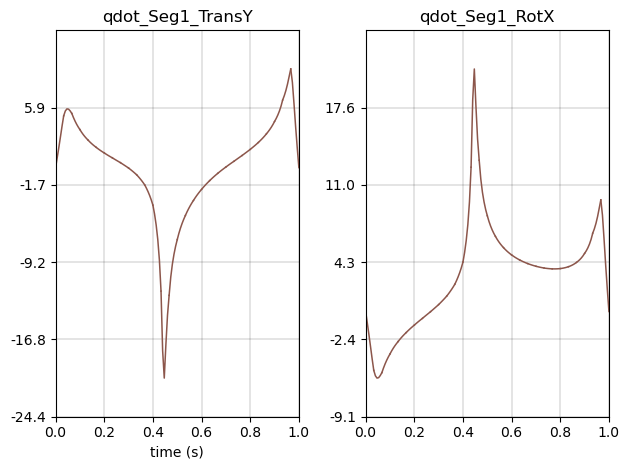

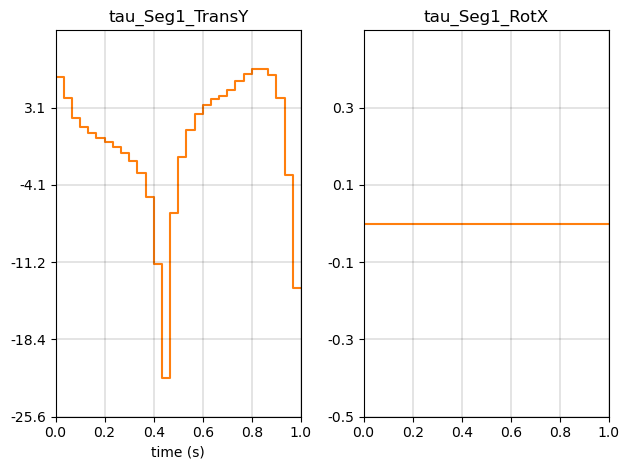

In [4]:
# Now let's print some results to the console and plot some graphs
sol.print_cost()
sol.graphs(automatically_organize=False)

In [1]:
viz = sol.animate(show_now=False)
ViewInteractiveWidget(viz[0].vtk_window.avatar_widget.GetRenderWindow())

NameError: name 'sol' is not defined